## Language Analysis of CFPB data

https://www.kaggle.com/mmrosenb/d/cfpb/us-consumer-finance-complaints/language-analysis

In [30]:
import numpy as np
import pandas as pd
import nltk
import collections as co
from io import BytesIO as StringIO #  need this to fix stringIO 
import matplotlib.pyplot as plt
import warnings
from IPython.display import display, HTML, Markdown

%matplotlib inline
def printmd(string):
    display(Markdown(string))
alphaLev = 0.5

In [31]:
d = pd.read_csv('../data/Consumer_Complaints_with_Consumer_Complaint_Narratives.csv')
d=d[d['Consumer complaint narrative'].notnull()]

In [32]:
s=StringIO()
d['Consumer complaint narrative'].apply(lambda x: s.write(x))

k=s.getvalue()
s.close()
k=k.lower()
k=k.split()

In [33]:
# Next only want valid strings
words = co.Counter(nltk.corpus.words.words())
stopWords =co.Counter( nltk.corpus.stopwords.words() )
k=[i for i in k if i in words and i not in stopWords]
c = co.Counter(k)
printmd("We see that we $" + str(len(k)) + "$ legal word tokens in our corpus. There are $" + str(
        len(list(c.most_common())))
       + "$ legal non-stopword types in our corpus.")

We see that we $4710290$ legal word tokens in our corpus. There are $14800$ legal non-stopword types in our corpus.

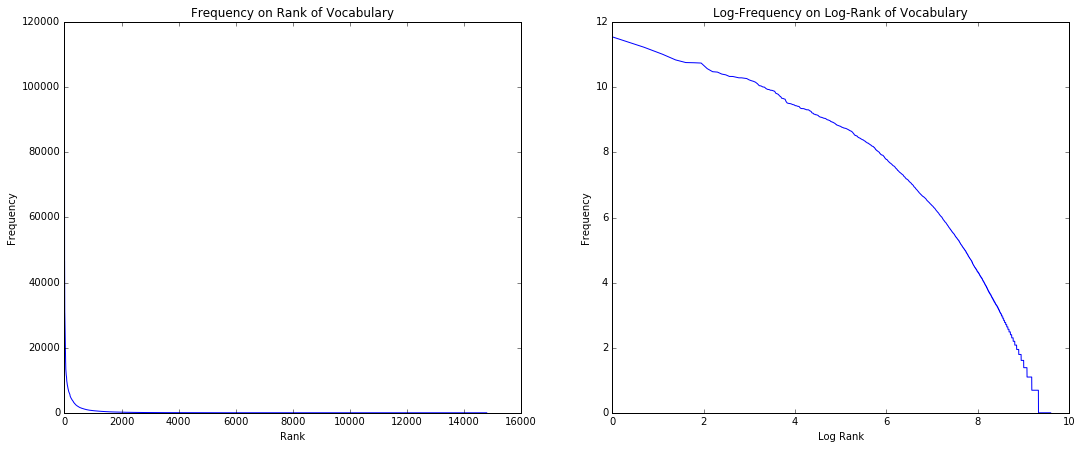

_Figure 1: Frequency-Rank Graphs of Our Vocabulary._

,Word,Frequency
0,credit,103704
1,account,75449
2,would,60852
3,loan,51092
4,bank,47113
5,payment,46834
6,told,46397
7,received,39057
8,debt,35576
9,mortgage,35136


_Table 1: The $15$ most frequent words with their frequencies_

,Word,Frequency
14785,trimester,1
14786,teaming,1
14787,sufferer,1
14788,atter,1
14789,demonize,1
14790,bating,1
14791,withstood,1
14792,abdication,1
14793,splashy,1
14794,backer,1


_Table 2: The $15$ least frequent words with their frequencies_

In [34]:
wordFrequencyFrame = pd.DataFrame(c.most_common(len(c)),columns = ["Word","Frequency"])
#plot frequency on rank
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
#freq-rank
ax1.plot(wordFrequencyFrame.index,wordFrequencyFrame["Frequency"])
ax1.set_title("Frequency on Rank of Vocabulary")
ax1.set_xlabel("Rank")
ax1.set_ylabel("Frequency")
#freq-logRank
ax2.plot(np.log(wordFrequencyFrame.index + 1),np.log(wordFrequencyFrame["Frequency"]))
ax2.set_title("Log-Frequency on Log-Rank of Vocabulary")
ax2.set_xlabel("Log Rank")
ax2.set_ylabel("Frequency")
plt.show()
printmd("_Figure 1: Frequency-Rank Graphs of Our Vocabulary._")
#get 15 most common
top15FrequencyFrame = wordFrequencyFrame.iloc[0:15,:]
display(top15FrequencyFrame)
printmd("_Table 1: The $15$ most frequent words with their frequencies_")
#get 15 least common
bottom15FrequencyFrame = wordFrequencyFrame.iloc[(wordFrequencyFrame.shape[0]-15):wordFrequencyFrame.shape[0],:]
display(bottom15FrequencyFrame)
printmd("_Table 2: The $15$ least frequent words with their frequencies_")


In [35]:
#get token-type list
typeSet = set([]) #we will add to this over time
typeTokenList = [] #we will add tuples to this
for i in range(len(k)):
    givenToken = k[i]
    if (givenToken not in typeSet): #we should get a new type count
        typeSet.add(givenToken)
    #then add information to type-token list
    typeTokenList.append((i+1,len(typeSet)))

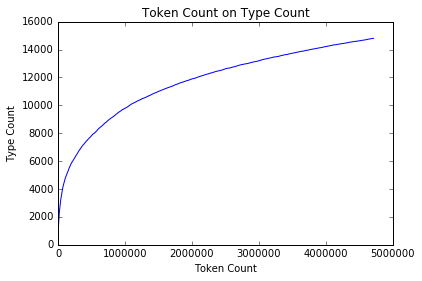

_Figure 2: Type-Token Graph for full vocabulary._

In [36]:
#then plot
typeTokenFrame = pd.DataFrame(typeTokenList,columns = ["Token Count","Type Count"])
plt.plot(typeTokenFrame["Token Count"],typeTokenFrame["Type Count"])
plt.xlabel("Token Count")
plt.ylabel("Type Count")
plt.title("Token Count on Type Count")
plt.show()
printmd("_Figure 2: Type-Token Graph for full vocabulary._")


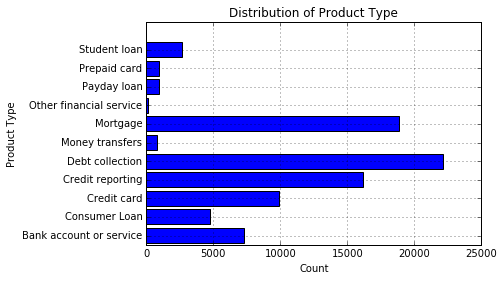

_Figure 3: Distribution of product types._

The number of narratives of the product type 'Other financial service' is $131$.

In [38]:
productCountFrame = complaintNarrativeFrame.groupby("Product")["Consumer complaint narrative"].count()
#from pylab import *
#val = 3+10*rand(5)    # the bar lengths
pos = np.arange(productCountFrame.shape[0])+.5    # the bar centers on the y axis

plt.barh(pos,productCountFrame, align='center')
plt.yticks(pos,productCountFrame.index)
plt.xlabel('Count')
plt.ylabel("Product Type")
plt.title('Distribution of Product Type')
plt.grid(True)
plt.show()
printmd("_Figure 3: Distribution of product types._")
printmd("The number of narratives of the product type 'Other financial service' is $" + str(
        productCountFrame["Other financial service"]) + "$.")

In [43]:
#declare functions before making type-token procedures
def makeTypeTokenFrame(tokenList):
    #helper that makes our type-token frame for a given token list
    typeSet = set([]) #we will add to this over time
    typeTokenList = [] #we will add tuples to this
    for i in range(len(tokenList)):
        givenToken = tokenList[i]
        if (givenToken not in typeSet): #we should get a new type count
            typeSet.add(givenToken)
        #then add information to type-token list
        typeTokenList.append((i+1,len(typeSet)))
    return pd.DataFrame(typeTokenList,columns = ["Token Count","Type Count"])

def makeTokenList(consumerComplaintFrame):
    #helper that makes token list from the given complaint frame
    s = StringIO()
    consumerComplaintFrame["Consumer complaint narrative"].apply(lambda x: s.write(x))
    k = s.getvalue() #gets string of unprocessed words
    s.close()
    #get actual unprocessed words
    #k = k.lower()
    k = k.split()
    k = [i for i in k if i in words and i not in stopWords] #only consider legal words
    return k

def getTokenTypeFrameForProduct(consumerComplaintFrame,productName):
    #helper that gets our token-type frame for narratives of a given product name
    #get observations with this product name
    givenProductComplaintFrame = consumerComplaintFrame[consumerComplaintFrame["Product"] == productName]
    #then get token list
    tokenList = makeTokenList(givenProductComplaintFrame)
    #then make type-token frame
    return makeTypeTokenFrame(tokenList)

In [44]:
#run through our observations
typeTokenFrameDict = {} #we will adds to this
for productName in productCountFrame.index:
    typeTokenFrameDict[productName] = getTokenTypeFrameForProduct(complaintNarrativeFrame,productName)

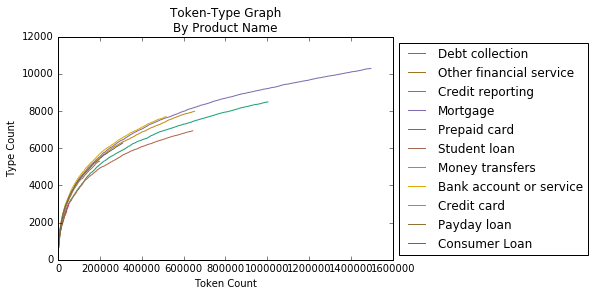

_Figure 4: Token-Type Graph By Product Name._

In [45]:
cmap = plt.get_cmap('Dark2')
colorList = [cmap(i) for i in np.linspace(0, 1, len(typeTokenFrameDict))]
for i in range(len(typeTokenFrameDict)):
    productName = list(typeTokenFrameDict)[i]
    givenProductTokenTypeFrame = typeTokenFrameDict[productName]
    plt.plot(givenProductTokenTypeFrame["Token Count"],
             givenProductTokenTypeFrame["Type Count"],label = productName,
            c = colorList[i])
plt.legend(bbox_to_anchor = (1.6,1))
plt.xlabel("Token Count")
plt.ylabel("Type Count")
plt.title("Token-Type Graph\nBy Product Name")
plt.show()
printmd("_Figure 4: Token-Type Graph By Product Name._")

In [48]:
def getTokenTypeFrameForDispute(consumerComplaintFrame,disputeLev):
    #helper that gets our token-type frame for narratives of a dispute level
    #get observations with this product name
    givenDisputeComplaintFrame = consumerComplaintFrame[consumerComplaintFrame["Consumer disputed?"] == disputeLev]
    #then get token list
    tokenList = makeTokenList(givenDisputeComplaintFrame)
    #then make type-token frame
    return makeTypeTokenFrame(tokenList)

In [49]:
consumerDisputeDict = {} #we will add to this
for disputeLev in complaintNarrativeFrame["Consumer disputed?"].unique():
    consumerDisputeDict[disputeLev] = getTokenTypeFrameForDispute(complaintNarrativeFrame,disputeLev)

AttributeError: 'Series' object has no attribute 'find'

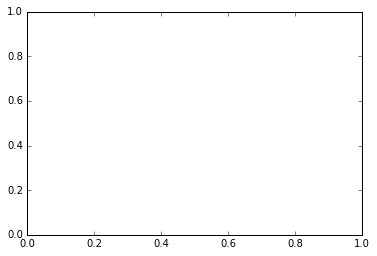

In [55]:
for disputeLev in consumerDisputeDict:
    DisputeTokenTypeFrame = consumerDisputeDict[disputeLev]
    plt.plot(DisputeTokenTypeFrame["Token Count"], DisputeTokenTypeFrame["Type Count"],label = disputeLev)
plt.legend(bbox_to_anchor = (1.3,1))
plt.xlabel("Token Count")
plt.ylabel("Type Count")
plt.title("Token-Type Graph\nBy Whether Consumer Disputed")
plt.show()
printmd("_Figure 5: Token-Type Graph By whether the consumer disputed._")